In [1]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def load_data(annotation_file, image_dir, target_size=(224, 224)):
    annotations = pd.read_csv(annotation_file)

    images = []
    bboxes = []

    for _, row in annotations.iterrows():
        # Get bounding box coordinates and normalize
        x_min = row['xmin']
        y_min = row['ymin']
        x_max = row['xmax']
        y_max = row['ymax']
        width = row['width']
        height = row['height']
        
        # Normalize bounding box coordinates
        bbox = [x_min / width, y_min / height, x_max / width, y_max / height]
        
        # Construct the full image path
        img_path = os.path.join(image_dir, row['filename'])
        
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Load the image and resize it to the target size
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, target_size)
        
        images.append(img)
        bboxes.append(bbox)

    # Convert to NumPy arrays
    images = np.array(images) / 255.0  # Normalize pixel values
    bboxes = np.array(bboxes)
    
    return images, bboxes


In [4]:
annotation_file = r'D:\table_detection\nutrition table.v2i.tensorflow\train\_annotations.csv'
image_dir = r'D:\table_detection\nutrition table.v2i.tensorflow\train'

# Load data
images, bboxes = load_data(annotation_file, image_dir)

In [5]:
# Manual normalization and denormalization
def normalize_bbox(bbox, image_width, image_height):
    return [bbox[0] / image_width, bbox[1] / image_height, bbox[2] / image_width, bbox[3] / image_height]

def denormalize_bbox(bbox, image_width, image_height):
    return [int(bbox[0] * image_width), int(bbox[1] * image_height), int(bbox[2] * image_width), int(bbox[3] * image_height)]

# Example augmentation pipeline
def augment_data(image, bboxes, class_labels):
    image_height, image_width = image.shape[:2]

    # Normalize bounding boxes
    normalized_bboxes = [normalize_bbox(bbox, image_width, image_height) for bbox in bboxes]

    # Apply augmentations
    transform = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=15, p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.4),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
    )

    # Perform augmentation
    augmented = transform(image=image, bboxes=normalized_bboxes, class_labels=class_labels)

    # Denormalize bounding boxes
    augmented_bboxes = [
        denormalize_bbox(bbox, image_width, image_height) for bbox in augmented['bboxes']
    ]

    return augmented['image'], augmented_bboxes

In [10]:
# Define the CNN Model
def create_table_detection_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='sigmoid')  # Output bounding box coordinates (normalized)
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [7]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [11]:
model = create_table_detection_model(input_shape=(224, 224, 3))

In [16]:
optimizer = Adam(learning_rate=0.00001)  # Coba dengan optimizer Adam dan learning rate lebih rendah

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=8, callbacks=[early_stopping])

Epoch 1/50
67/67 [==============================] - 2s 30ms/step - loss: 0.4445 - accuracy: 0.9346 - val_loss: 0.5214 - val_accuracy: 0.6716
Epoch 2/50
67/67 [==============================] - 2s 28ms/step - loss: 0.4448 - accuracy: 0.9346 - val_loss: 0.5227 - val_accuracy: 0.6716
Epoch 3/50
67/67 [==============================] - 2s 29ms/step - loss: 0.4454 - accuracy: 0.9346 - val_loss: 0.5184 - val_accuracy: 0.6791
Epoch 4/50
67/67 [==============================] - 2s 29ms/step - loss: 0.4451 - accuracy: 0.9234 - val_loss: 0.5183 - val_accuracy: 0.6791
Epoch 5/50
67/67 [==============================] - 2s 27ms/step - loss: 0.4436 - accuracy: 0.9477 - val_loss: 0.5216 - val_accuracy: 0.6716
Epoch 6/50
67/67 [==============================] - 2s 26ms/step - loss: 0.4434 - accuracy: 0.9439 - val_loss: 0.5199 - val_accuracy: 0.6642
Epoch 7/50
67/67 [==============================] - 2s 27ms/step - loss: 0.4431 - accuracy: 0.9364 - val_loss: 0.5220 - val_accuracy: 0.6493
Epoch 8/50
67

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

17/17 [==============================] - 0s 18ms/step - loss: 0.4468 - accuracy: 0.9364
Test Accuracy: 93.64%


In [30]:
# Save history to a pickle file
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [31]:
# # Load the latest checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# if latest_checkpoint:
#     print(f"Restoring model from checkpoint: {latest_checkpoint}")
#     model.load_weights(latest_checkpoint)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
tflite_model_path = "model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved as TFLite: {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\theod\AppData\Local\Temp\tmpmuxp4m2_\assets


INFO:tensorflow:Assets written to: C:\Users\theod\AppData\Local\Temp\tmpmuxp4m2_\assets


Model saved as TFLite: model.tflite


1/1 [==============================] - 0s 17ms/step


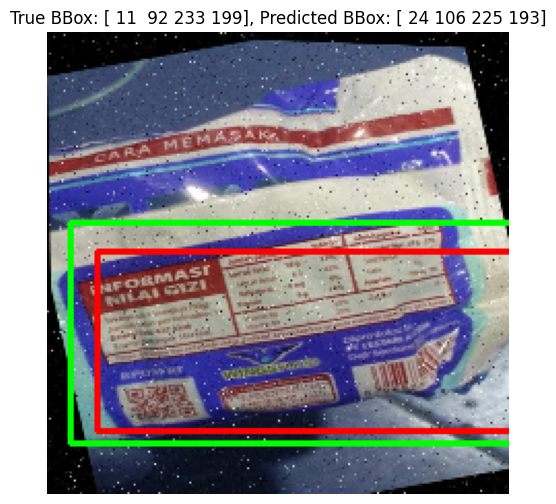

In [44]:
# Function to visualize model predictions
def visualize_predictions(model, X_test, y_test, num_samples=5, target_size=(256, 256)):
    """
    Visualizes the model's bounding box predictions on test images.
    
    Parameters:
    - model: Trained model for bounding box prediction.
    - X_test: Test images (input for the model).
    - y_test: Ground truth bounding boxes for the test images.
    - num_samples: Number of images to visualize.
    - target_size: Size to which the images were resized during preprocessing.
    """
    # Select a few random samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Iterate through selected samples
    for idx in indices:
        # Get the test image and ground truth bounding box
        test_image = X_test[idx]
        true_bbox = y_test[idx]
        
        # Make prediction using the model
        predicted_bbox = model.predict(test_image[np.newaxis, ...])[0]  # Expand dimensions for batch size
        
        # Scale the bounding boxes back to the original image size
        true_bbox = np.array(true_bbox) * np.array([target_size[0], target_size[1], target_size[0], target_size[1]])
        predicted_bbox = np.array(predicted_bbox) * np.array([target_size[0], target_size[1], target_size[0], target_size[1]])
        
        # Convert normalized bounding boxes to integer pixel values
        true_bbox = true_bbox.astype(int)
        predicted_bbox = predicted_bbox.astype(int)
        
        # Draw bounding boxes on the test image
        image = (test_image * 255).astype(np.uint8)  # Convert normalized image to original pixel values
        image = cv2.rectangle(image.copy(), (true_bbox[0], true_bbox[1]), (true_bbox[2], true_bbox[3]), (0, 255, 0), 2)  # True bbox (green)
        image = cv2.rectangle(image.copy(), (predicted_bbox[0], predicted_bbox[1]), (predicted_bbox[2], predicted_bbox[3]), (255, 0, 0), 2)  # Predicted bbox (blue)
        
        # Display the image with bounding boxes
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"True BBox: {true_bbox}, Predicted BBox: {predicted_bbox}")
        plt.axis("off")
        plt.show()

# Assuming `model` is the trained model, and `X_test`, `y_test` are the test data
  # Uncomment this line after the model is trained and data is ready
visualize_predictions(model, X_train, y_train, num_samples=1)
# Let me know if you'd like me to train a sample model or test this with your dataset!